In [255]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

In [256]:
!pip install pyspark

In [257]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
    .master("local[2]")\
    .appName("Lesson_2")\
    .config("spark.executor.instances",2)\
    .config("spark.executor.memory",'2g')\
    .config("spark.executor.cores",1)\
    .getOrCreate()
sc = spark.sparkContext

# Кредитный скоринг
При принятии решения о выдаче кредита или займа учитывается т.н. «Кредитный скоринг» — рейтинг платежеспособности клиента. ИИ на основе модели, которую просчитывает машинное обучение — в ней много параметров — возраст, зарплата, кредитная история, наличие недвижимости, автомобиля, судимости и других признаков, после обработки которых выносится положительное или отрицательное решение

# Данные:
[скачать](https://drive.google.com/file/d/1MuAyZiIm3b_r-AgQSj78tsRPqZpvv_2s/view?usp=sharing)

**application_record.csv**
*   Feature name	Explanation	Remarks
*   ID	Client number	
*   CODE_GENDER	Gender	
*   FLAG_OWN_CAR	Is there a car	
*   FLAG_OWN_REALTY	Is there a property	
*   CNT_CHILDREN	Number of children	
*   AMT_INCOME_TOTAL	Annual income	
*   NAME_INCOME_TYPE	Income category	
*   NAME_EDUCATION_TYPE	Education level	
*   NAME_FAMILY_STATUS	Marital status	
*   NAME_HOUSING_TYPE	Way of living	
*   DAYS_BIRTH	Birthday	Count backwards from current day (0), -1 means yesterday
*   DAYS_EMPLOYED	Start date of employment	Count backwards from current day(0). If positive, it means the person currently unemployed.
FLAG_MOBIL	Is there a mobile phone	
*   FLAG_WORK_PHONE	Is there a work phone	
*   FLAG_PHONE	Is there a phone	
*   FLAG_EMAIL	Is there an email	
*   OCCUPATION_TYPE	Occupation	
*   CNT_FAM_MEMBERS	Family size	

**credit_record.csv**
*   Feature name	Explanation	Remarks
*   ID	Client number	
*   MONTHS_BALANCE	Record month	The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on
*   STATUS	Status	
   *   0: 1-29 days past due
   *   1: 30-59 days past due 
   *   2: 60-89 days overdue 
   *   3: 90-119 days overdue 
   *   4: 120-149 days overdue 
    *   5: Overdue or bad debts, write-offs for more than 150 days
    *   C: paid off that month X: No loan for the month


In [258]:
# Импорт библиотек
from pyspark.sql import functions as F
from pyspark.ml.feature import HashingTF, Tokenizer, VectorAssembler, StringIndexer, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

## Считываем данные

In [259]:
# Ниже мы, для тех у кого были просрчоки больше 60 дней хоть раз,ставим в таргет 1.

# Считываем данные
data = spark.read.csv('./application_record.csv', encoding = 'utf-8', header = True, inferSchema = True)
record = spark.read.csv('./credit_record.csv', encoding = 'utf-8', header = True, inferSchema = True)

data.printSchema()
record.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- FLAG_MOBIL: integer (nullable = true)
 |-- FLAG_WORK_PHONE: integer (nullable = true)
 |-- FLAG_PHONE: integer (nullable = true)
 |-- FLAG_EMAIL: integer (nullable = true)
 |-- OCCUPATION_TYPE: string (nullable = true)
 |-- CNT_FAM_MEMBERS: double (nullable = true)

root
 |-- ID: integer (nullable = true)
 |-- MONTHS_BALANCE: integer (nullable = true)
 |-- STATUS: string (nullable = true)



In [260]:
data.count()

438557

In [261]:
record.count()

1048575

In [262]:
# Добавляем срок кредита к параметрма выдачи кредита
begin_month = record.groupBy(F.col('ID').alias('ID_month')).agg((F.min('MONTHS_BALANCE') * (-1)).alias('begin_month'))

begin_month.show(3)
begin_month.count()

+--------+-----------+
|ID_month|begin_month|
+--------+-----------+
| 5001812|         22|
| 5001849|          8|
| 5001921|         19|
+--------+-----------+
only showing top 3 rows



45985

In [263]:
new_data = data.join(begin_month, on = [data.ID == begin_month.ID_month], how = 'left')
new_data.show(3)
new_data.count()

+-------+-----------+------------+---------------+------------+----------------+----------------+--------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+--------+-----------+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|ID_month|begin_month|
+-------+-----------+------------+---------------+------------+----------------+----------------+--------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+--------+-----------+
|5008804|          M|           Y|              Y|           0|        427500.0|         Working|    Higher education|    Civil marriage| Rented apartm

438557

In [264]:
# Пример данных из полученного DataFrame'а
new_data.select('ID', 'CODE_GENDER', 'CNT_CHILDREN', 'begin_month').show(10)

+-------+-----------+------------+-----------+
|     ID|CODE_GENDER|CNT_CHILDREN|begin_month|
+-------+-----------+------------+-----------+
|5008804|          M|           0|         15|
|5008805|          M|           0|         14|
|5008806|          M|           0|         29|
|5008808|          F|           0|          4|
|5008809|          F|           0|         26|
|5008810|          F|           0|         26|
|5008811|          F|           0|         38|
|5008812|          F|           0|         20|
|5008813|          F|           0|         16|
|5008814|          F|           0|         17|
+-------+-----------+------------+-----------+
only showing top 10 rows



In [265]:
# Больше 60, то это просрочка ставим - Yes, если просрочка есть за срок кредита,то так же ставим Yes
record = record.withColumn('dep_value', F.when(F.col('STATUS') == 2, 'YES') \
                                         .when(F.col('STATUS') == 3, 'YES') \
                                         .when(F.col('STATUS') == 4, 'YES') \
                                         .when(F.col('STATUS') == 5, 'YES') )
cpunt = record.select('ID', 'dep_value').groupBy('ID').agg(F.count(F.col('dep_value')).alias('dep_value'))
cpunt = cpunt.select('ID', F.when(F.col('dep_value') > 0, 'YES').when(F.col('dep_value') == 0, 'NO').alias('dep_value'))

In [266]:
cpunt.filter(F.col('dep_value') == 'YES').count()

667

In [267]:
cpunt.filter(F.col('dep_value') == 'NO').count()

45318

In [268]:
# Джойним всё вместе, заменяем Yea и No на 1 и 0
new_data = new_data.join(cpunt, on = 'ID', how = 'inner')

In [269]:
new_data.count()

36457

In [270]:
si = StringIndexer(inputCol = 'dep_value', outputCol = 'target')
si = si.fit(new_data)
new_data = si.transform(new_data)

In [271]:
new_data.count()

36457

In [272]:
new_data.filter(F.col('target') == 0.0).count()

35841

In [273]:
new_data.filter(F.col('target') == 1.0).count()

616

In [274]:
new_data.orderBy(F.col('ID')).show(5)

+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+--------+-----------+---------+------+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|ID_month|begin_month|dep_value|target|
+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+--------+-----------+---------+------+
|5008804|          M|           Y|              Y|           0|        427500.0|  

In [296]:
# Упростим себе задачу и оставим только часть признаков
features = ['AMT_INCOME_TOTAL', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN']	
target = ['target',]
dataset_source = new_data.select(features + target)

In [297]:
dataset_source.count()

36457

In [298]:
dataset_source.orderBy(F.col('AMT_INCOME_TOTAL')).show(30)

+----------------+-----------+------------+---------------+------------+------+
|AMT_INCOME_TOTAL|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|target|
+----------------+-----------+------------+---------------+------------+------+
|         27000.0|          F|           N|              N|           0|   0.0|
|         27000.0|          F|           N|              N|           0|   0.0|
|         27000.0|          F|           N|              Y|           0|   0.0|
|         29250.0|          F|           Y|              Y|           0|   0.0|
|         29250.0|          F|           Y|              Y|           0|   0.0|
|         29250.0|          F|           Y|              Y|           0|   0.0|
|         29250.0|          F|           Y|              Y|           0|   0.0|
|         29250.0|          F|           Y|              Y|           0|   0.0|
|         29250.0|          F|           Y|              Y|           0|   0.0|
|         29250.0|          F|          

У нас есть выборка, где указаны параметры клиента и вышел ли он на просрочку или нет.

Дальше будем исследовать, есть ли связь между этими параметрами и возвратом кредита.

Можете уже на этом этапе предложить гипотезы, а мы их проверим. Предположим, что чем больше детей, тем меньше вероятность, что будет просрочка.

In [299]:
# Делаем последовательно. Не через PipeLine.
dataset = dataset_source.select('*')

In [300]:
# Превращаем категориальные фаткоры ('CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY') в численные 
si_cg = StringIndexer(inputCol = 'CODE_GENDER', outputCol = 'CODE_GENDER_si')
si_cg = si_cg.fit(dataset)
dataset = si_cg.transform(dataset)

si_foc = StringIndexer(inputCol = 'FLAG_OWN_CAR', outputCol = 'FLAG_OWN_CAR_si')
si_foc = si_foc.fit(dataset)
dataset = si_foc.transform(dataset)

si_for = StringIndexer(inputCol = 'FLAG_OWN_REALTY', outputCol = 'FLAG_OWN_REALTY_si')
si_for = si_for.fit(dataset)
dataset = si_for.transform(dataset)


In [301]:
dataset.show()

+----------------+-----------+------------+---------------+------------+------+--------------+---------------+------------------+
|AMT_INCOME_TOTAL|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|target|CODE_GENDER_si|FLAG_OWN_CAR_si|FLAG_OWN_REALTY_si|
+----------------+-----------+------------+---------------+------------+------+--------------+---------------+------------------+
|        255150.0|          F|           N|              N|           0|   0.0|           0.0|            0.0|               1.0|
|        112500.0|          F|           N|              N|           0|   0.0|           0.0|            0.0|               1.0|
|        135000.0|          F|           N|              N|           0|   0.0|           0.0|            0.0|               1.0|
|        198000.0|          M|           N|              N|           0|   0.0|           1.0|            0.0|               1.0|
|        279000.0|          F|           N|              Y|           0|   0.0|           

In [302]:
# формируем вектора (features) из данных отдельных колонок
va = VectorAssembler(inputCols = ['AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'CODE_GENDER_si', 'FLAG_OWN_CAR_si', 'FLAG_OWN_REALTY_si'],
                     outputCol = 'pre_features')
dataset = va.transform(dataset)
dataset = dataset.select('AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'CODE_GENDER_si', 'FLAG_OWN_CAR_si', 'FLAG_OWN_REALTY_si', 
                         'pre_features', F.col('TARGET').alias('label'))

In [303]:
dataset.show(10)

+----------------+------------+--------------+---------------+------------------+--------------------+-----+
|AMT_INCOME_TOTAL|CNT_CHILDREN|CODE_GENDER_si|FLAG_OWN_CAR_si|FLAG_OWN_REALTY_si|        pre_features|label|
+----------------+------------+--------------+---------------+------------------+--------------------+-----+
|        255150.0|           0|           0.0|            0.0|               1.0|(5,[0,4],[255150....|  0.0|
|        112500.0|           0|           0.0|            0.0|               1.0|(5,[0,4],[112500....|  0.0|
|        135000.0|           0|           0.0|            0.0|               1.0|(5,[0,4],[135000....|  0.0|
|        198000.0|           0|           1.0|            0.0|               1.0|[198000.0,0.0,1.0...|  0.0|
|        279000.0|           0|           0.0|            0.0|               0.0|  (5,[0],[279000.0])|  0.0|
|        225000.0|           0|           1.0|            1.0|               0.0|[225000.0,0.0,1.0...|  0.0|
|        216000.0| 

In [304]:
# Отскалируем полученные вектора
mms = MinMaxScaler(inputCol = 'pre_features', outputCol = 'features')
mms = mms.fit(dataset)
dataset = mms.transform(dataset)

In [305]:
dataset.show()

+----------------+------------+--------------+---------------+------------------+--------------------+-----+--------------------+
|AMT_INCOME_TOTAL|CNT_CHILDREN|CODE_GENDER_si|FLAG_OWN_CAR_si|FLAG_OWN_REALTY_si|        pre_features|label|            features|
+----------------+------------+--------------+---------------+------------------+--------------------+-----+--------------------+
|        255150.0|           0|           0.0|            0.0|               1.0|(5,[0,4],[255150....|  0.0|(5,[0,4],[0.14738...|
|        112500.0|           0|           0.0|            0.0|               1.0|(5,[0,4],[112500....|  0.0|(5,[0,4],[0.05523...|
|        135000.0|           0|           0.0|            0.0|               1.0|(5,[0,4],[135000....|  0.0|(5,[0,4],[0.06976...|
|        198000.0|           0|           1.0|            0.0|               1.0|[198000.0,0.0,1.0...|  0.0|[0.11046511627906...|
|        279000.0|           0|           0.0|            0.0|               0.0|  (5,[0],

In [306]:
# Разделим выборку на трейн и тест, на трейн будем обучать модель, на тест валидировать.
train, test = dataset.randomSplit([0.7, 0.3])

#  Модель

Модель будет находить коэффициенты alpha и beta, где Х наши колонки, факторы. Погуглите подробнее, но данная формула даёт вероятность события.

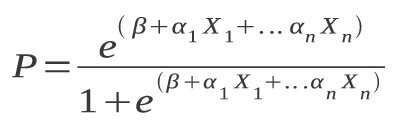

In [307]:
lr = LogisticRegression()

lr = lr.fit(train)

train = lr.transform(train)
test = lr.transform(test)

In [308]:
train.printSchema()
test.printSchema()

root
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- CODE_GENDER_si: double (nullable = false)
 |-- FLAG_OWN_CAR_si: double (nullable = false)
 |-- FLAG_OWN_REALTY_si: double (nullable = false)
 |-- pre_features: vector (nullable = true)
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)

root
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- CODE_GENDER_si: double (nullable = false)
 |-- FLAG_OWN_CAR_si: double (nullable = false)
 |-- FLAG_OWN_REALTY_si: double (nullable = false)
 |-- pre_features: vector (nullable = true)
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [316]:
# Считаем score
evaluator = BinaryClassificationEvaluator()
train_score, test_score = evaluator.evaluate(train), evaluator.evaluate(test)
print(f'Точность модели на трейне {train_score}, на тесте {test_score}')

Точность модели на трейне 0.5560676975483256, на тесте 0.5586205529707002


Те же действия через PipeLine

In [320]:
dataset_pl = dataset_source.select('*')

In [321]:
# Создаем PipeLine, с помощью которого формируем вектора для модели.
si_cg = StringIndexer(inputCol = 'CODE_GENDER', outputCol = 'CODE_GENDER_si')
si_foc = StringIndexer(inputCol = 'FLAG_OWN_CAR', outputCol = 'FLAG_OWN_CAR_si')
si_for = StringIndexer(inputCol = 'FLAG_OWN_REALTY', outputCol = 'FLAG_OWN_REALTY_si')
va = VectorAssembler(inputCols = ['AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'CODE_GENDER_si', 'FLAG_OWN_CAR_si', 'FLAG_OWN_REALTY_si'],
                     outputCol = 'pre_features')
mms = MinMaxScaler(inputCol = va.getOutputCol(), outputCol = 'features')

pipe = Pipeline(stages = [si_cg, si_foc, si_for, va, mms])
pipe = pipe.fit(dataset_pl)
dataset_pl = pipe.transform(dataset_pl)
dataset_pl = dataset_pl.select('AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'CODE_GENDER_si', 'FLAG_OWN_CAR_si', 'FLAG_OWN_REALTY_si', 
                               'pre_features', F.col('TARGET').alias('label'), 'features')

In [324]:
# Разделим выборку на трейн и тест, на трейн будем обучать модель, на тест валидировать.
train_pl, test_pl = dataset_pl.randomSplit([0.7, 0.3])

In [325]:
# Создаем модель.
lr = LogisticRegression()
lr = lr.fit(train_pl)
train_pl = lr.transform(train_pl) 
test_pl = lr.transform(test_pl)

# Считаем score.
evaluator = BinaryClassificationEvaluator()
evaluator = BinaryClassificationEvaluator()
train_pl_score, test_pl_score = evaluator.evaluate(train_pl), evaluator.evaluate(test_pl)
print(f'Точность модели на трейне {train_pl_score}, на тесте {test_pl_score}')

Точность модели на трейне 0.5559549684415218, на тесте 0.5477153996955326


In [326]:
train_pl.filter(F.col('prediction') == 1.0).count()

0

In [327]:
test_pl.filter(F.col('prediction') == 1.0).count()

0